In [1]:
 !pip install datatable
 !pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.9 MB 80 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 10.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=85e9dadbf0afb2e30301246cfcbe7e5cf9e615b998d7d61eb553cf1080772741
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
import datatable as dt
#import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Stop Words

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #spanish
stop_words.extend(['\n', 'nan'])
stop_words.extend(['stay', 'stayed', 'service', 'got', 'room', 'night', 'food', 'did', 'rooms', 
'day', 'resort', 'hotel', 'beach', 'staff', 'great', 'good', 'nice'])

### Dataset

In [6]:
df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv', decimal = '.', sep = ',')

conditions = [df.Rating.isin([1,2]), df.Rating.isin([3]), df.Rating.isin([4,5])]
values = [0,0,1]

df['Cluster'] =np.select(conditions, values)

df

,Review,Rating,Cluster
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,1
20487,great location price view hotel great quick pl...,4,1
20488,"ok just looks nice modern outside, desk staff ...",2,0
20489,hotel theft ruined vacation hotel opened sept ...,1,0


### Tokenize words and Clean-up text

In [7]:
data = df[df['Cluster'] == 1 ]

In [8]:
%%time
# Convert to list
data = data.Review.astype('str') # DESCRIPCION OBSERVACIONES
data = data.values.tolist()


tokens = [t.lower() for t in data if t.lower() not in stop_words]
tokens = [re.sub('\s+', ' ', sent) for sent in tokens]
tokens = [re.sub('\d', ' ', sent) for sent in tokens] #Elimino los numeros
tokens = [re.sub(' +', ' ', sent) for sent in tokens] #Elimino multiples espacios en blanco
tokens = [str(sent).strip() for sent in tokens] # elimina espacios en blanco antes y despues del token
tokens = [re.sub('[^A-Za-z0-9]+', ' ', sent) for sent in tokens] #elimina los caracteres especiales


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(tokens))

data_words[:10]

CPU times: user 6.01 s, sys: 167 ms, total: 6.18 s
Wall time: 6.21 s


### Creating Bigram and Trigram Models

In [9]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=0.2) # higher threshold fewer phrases. valores entre 0 y uno
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 35.3 s, sys: 282 ms, total: 35.6 s
Wall time: 35.6 s


In [10]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[1452]]])

['outstanding', 'price_location', 'awesome', 'arrived', 'no', 'day', 'holiday', 'greeted', 'warm_welcome', 'chateau', 'lemoyne', 'desk', 'upgraded_suite', 'booked', 'free', 'cocktail', 'reception', 'lounge', 'room_beautiful', 'clean', 'balcony', 'courtyard', 'netya', 'desk', 'soooo', 'sweet', 'stay', 'everytime', 'visit', 'location_best']


### Remove Stopwords, Make Bigrams and Lemmatize

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# !spacy download es_core_news_md

In [13]:
# !spacy download en_core_web_sm


In [14]:
%%time
#Let’s call the functions in order.
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) #es_core_news_md

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expensive', 'parking', 'deal', 'anniversary', 'evening', 'easy', 'little_disappointe', 'view', 'clean', 'comfortable', 'wake', 'stiff', 'neck', 'high', 'pillow', 'soundproof', 'hear', 'music', 'morning', 'loud', 'bang', 'door', 'open', 'close', 'talk', 'hallway', 'maybe', 'noisy', 'neighbor', 'aveda', 'goldfish', 'touch', 'take', 'advantage', 'stay', 'longer', 'distance', 'shopping', 'overall_experience', 'pay', 'parking']]
CPU times: user 1min 37s, sys: 814 ms, total: 1min 38s
Wall time: 1min 38s


### Create the Dictionary and Corpus needed for Topic Modeling

In [15]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


CPU times: user 2.11 s, sys: 69.1 ms, total: 2.17 s
Wall time: 2.18 s


In [16]:
id2word[2]

'aveda'

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('advantage', 1),
  ('anniversary', 1),
  ('aveda', 1),
  ('bang', 1),
  ('clean', 1),
  ('close', 1),
  ('comfortable', 1),
  ('deal', 1),
  ('distance', 1),
  ('door', 1),
  ('easy', 1),
  ('evening', 1),
  ('expensive', 1),
  ('goldfish', 1),
  ('hallway', 1),
  ('hear', 1),
  ('high', 1),
  ('little_disappointe', 1),
  ('longer', 1),
  ('loud', 1),
  ('maybe', 1),
  ('morning', 1),
  ('music', 1),
  ('neck', 1),
  ('neighbor', 1),
  ('noisy', 1),
  ('open', 1),
  ('overall_experience', 1),
  ('parking', 2),
  ('pay', 1),
  ('pillow', 1),
  ('shopping', 1),
  ('soundproof', 1),
  ('stay', 1),
  ('stiff', 1),
  ('take', 1),
  ('talk', 1),
  ('touch', 1),
  ('view', 1),
  ('wake', 1)],
 [('goldfish', 1),
  ('touch', 1),
  ('animal', 2),
  ('area', 1),
  ('bathrobe', 1),
  ('big', 1),
  ('chain', 1),
  ('closed', 1),
  ('color', 1),
  ('cosy', 1),
  ('curtain', 1),
  ('downtown', 1),
  ('eclectic', 1),
  ('enjoy', 1),
  ('excellent', 1),
  ('feature', 1),
  ('feel', 1),
  ('free_wire

### Building the Topic Model

* chunksize: is the number of documents to be used in each training chunk. 
* update_every: determines how often the model parameters should be updated and 
* passes: is the total number of training passes.

In [39]:
%%time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           #per_word_topics=True
                                             )

CPU times: user 2min 4s, sys: 1.09 s, total: 2min 5s
Wall time: 2min 6s


In [40]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"excellent" + 0.006*"breakfast" + 0.006*"place" + 0.006*"small" + '
  '0.005*"area" + 0.005*"book" + 0.005*"bed" + 0.005*"bathroom" + 0.005*"look" '
  '+ 0.005*"view"'),
 (1,
  '0.011*"go" + 0.011*"time" + 0.010*"pool" + 0.008*"drink" + 0.008*"people" + '
  '0.006*"want" + 0.006*"restaurant" + 0.006*"say" + 0.006*"water" + '
  '0.005*"leave"')]


### Compute Model Perplexity and Coherence Score

In [20]:
# Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.335460448838779


### Visualize the topics-keywords

In [21]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
0      0.13207  0.0       1        1  54.866338
1     -0.13207  0.0       2        1  45.133662, topic_info=          Term         Freq        Total Category  logprob  loglift
111         go  4572.000000  4572.000000  Default  30.0000  30.0000
577       pool  3264.000000  3264.000000  Default  29.0000  29.0000
360     people  2921.000000  2921.000000  Default  28.0000  28.0000
194      drink  2789.000000  2789.000000  Default  27.0000  27.0000
405  breakfast  3211.000000  3211.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
560        bar  1668.947207  2889.487015   Topic2  -5.4051   0.2467
75       think  1622.149378  2741.797152   Topic2  -5.4336   0.2707
324     little  1596.324745  2820.050618   Topic2  -5.4496   0.2265
455        ask  1393.513743  2292.807802   Topic2  -5.5855   0.2976
133      place  1601.735503  4150.500931   Topic2  -5.4462  -0.1566

[162 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
176       1  0.999277    access
176       2  0.001336    access
78        1  0.001199  activity
78        2  0.999705  activity
684       1  0.161871   amazing
...     ...       ...       ...
393       2  0.830858      week
237       1  0.999021   weekend
237       2  0.001138   weekend
546       1  0.999525    window
546       2  0.001217    window

[251 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### Save the model

In [22]:
# path_name = "./Gensim_models/interaction_model_descripcion.model"
# lda_model.save(path_name)

In [23]:
# new = gensim.models.ldamodel.LdaModel.load(path_name)
# model_new_topics = new.show_topics(formatted=False)
# pprint(new.print_topics(num_words=40))

### Building LDA Mallet Model (It is no longer available)

In [24]:
# mallet_path = '/home/sandovalj@lc.gc.local/tfx/mallet-2.0.8' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)

# # Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

### Finding the optimal number of topics for LDA

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state = 100, update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
# %%time
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

In [27]:
# # Show graph
# limit=10; start=2; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [28]:
# # Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#### Selecting the optimal model

In [29]:
# # Select the model and print the topics
# optimal_model = model_list[2]
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [30]:
# pyLDAvis.enable_notebook()
# vis_2 =  gensimvis.prepare(optimal_model, corpus, id2word)
# vis_2

Se escogió 3 Clusters porque a partir de 4 empieza a haber solapamiento y algunos clusters quedan vacios

### Save Optimal Model

In [31]:
#optimal_model.save("./Gensim_models/interaction_model_observacion_reclamos.model")

# new = gensim.models.ldamodel.LdaModel.load("./Gensim_models/interaction_model_descripcion_reclamos.model")
# model_new_topics = new.show_topics(formatted=False)
# pprint(new.print_topics(num_words=20))

In [32]:
# pprint(optimal_model.print_topics(num_words=10))

### Functions to sort the data

In [33]:
###############Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

##################Find the most representative document for each topic
def most_representative_records(df_topic_sents_keywords):
    # Group top 5 sentences under each topic
    sent_topics_sorteddf = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

    # Reset Index    
    sent_topics_sorteddf.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    
    return sent_topics_sorteddf

################Topic distribution across documents
def topic_distribution(df_topic_sents_keywords):
    # Number of Documents for Each Topic
    topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

    # Percentage of Documents for Each Topic
    topic_contribution = round(topic_counts/topic_counts.sum(), 4)

    # Topic Number and Keywords
    topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].value_counts()
    topic_num_keywords = pd.DataFrame(topic_num_keywords)
    topic_num_keywords = topic_num_keywords.reset_index().drop(0, axis=1)

    # Concatenate Column wise
    df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
    df_dominant_topics = df_dominant_topics.reset_index()
    df_dominant_topics = pd.concat([topic_num_keywords, df_dominant_topics], axis=1)
    # Change Column names
    df_dominant_topics.columns = ['Dominant_topic', 'Topic_Keywords', 'to_delete', 'Num_Documents', 'Perc_Documents']
    del  df_dominant_topics['to_delete']

    # Show
    return df_dominant_topics

### Finding the dominant topic in each sentence

In [34]:
optimal_model = lda_model 

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.8754,"breakfast, excellent, small, area, place, book...",nice hotel expensive parking got good deal sta...
1,1,0.0,0.6905,"breakfast, excellent, small, area, place, book...","unique, great stay, wonderful time hotel monac..."
2,2,1.0,0.5143,"go, time, pool, people, drink, want, restauran...","great stay great stay, went seahawk game aweso..."
3,3,0.0,0.5344,"breakfast, excellent, small, area, place, book...",love monaco staff husband stayed hotel crazy w...
4,4,0.0,0.8925,"breakfast, excellent, small, area, place, book...","cozy stay rainy city, husband spent 7 nights m..."
5,5,0.0,0.7615,"breakfast, excellent, small, area, place, book...","excellent staff, housekeeping quality hotel ch..."
6,6,0.0,0.8657,"breakfast, excellent, small, area, place, book...","hotel stayed hotel monaco cruise, rooms genero..."
7,7,0.0,0.8316,"breakfast, excellent, small, area, place, book...",excellent stayed hotel monaco past w/e delight...
8,8,0.0,0.7272,"breakfast, excellent, small, area, place, book...",nice value seattle stayed 4 nights late 2007. ...
9,9,0.0,0.8885,"breakfast, excellent, small, area, place, book...",nice hotel good location hotel kimpton design ...


In [42]:
df_dominant_topic[df_dominant_topic.Dominant_Topic == 1]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
2,2,1.0,0.5143,"go, time, pool, people, drink, want, restaurant, say, leave, water","great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called started making comments girlfriend cell phone buddy, took second realize just said fact speak language face priceless, ass told, said large city, told head doorman issue called cab company promply answer did n't, apologized offered pay taxi, bucks 2 miles stadium, game plan taxi return going humpin, great walk did n't mind, right christmas wonderful lights, homeless stowed away building entrances leave, police presence not greatest area stadium, activities 7 blocks pike street waterfront great coffee shops way, hotel mantained foyer awesome, wine tasting available evening, best dog, taking st. bernard time family, safes hotel located service desk room, bathroom huge jetted tub huge, funny house keeping walked girlfriend getting dressed, did n't hear knock doing turn service, screamed girlfriend screams hit floor laughing, started talking spanish worked, place recommend price, check online deals just good not better, besite contains deals vouchers travel websites n't tell,"
77,77,1.0,0.5599,"go, time, pool, people, drink, want, restaurant, say, leave, water","best bar lobby meet friend year, pop elevator oliver great place drinks people watching, great location,"
117,117,1.0,0.6239,"go, time, pool, people, drink, want, restaurant, say, leave, water","great service probably half star star hotel, guest services outstanding employees ask needed help walking getting hotel desk, ate hotel cafe 2nd floor quick bite checking steak sandwich tender tasted, hot water bathroom instant towels nice, paid 100 night priceline think parking hotel 21 dollars night.feel free ask questions,"
191,191,1.0,0.5319,"go, time, pool, people, drink, want, restaurant, say, leave, water","oh love place, lucky win gift certificate sorrento hotel beautiful place, thought look noses given donated gift certificate desk treated did concierge.the room lovely little small french press coffee actually not bad, cd player complimentary use cd including blues compilation listened took bath.the bathroom really beautiful lots white grey marble.the sorrento offers complimentary car service took friend capitol hill no time flat.if money stay time,"
204,204,1.0,0.5517,"go, time, pool, people, drink, want, restaurant, say, leave, water","kind considerate booked hotel reading reviews like best deal compared rates downtown hotels, reviews stated staff helpful friendly, case special way, attend mariners game saturday night running late coming eugene, unable stop hotel game, came game rental window broken owned stolen, called jeff hotel tell late sure hold room, finally arrived 2 police came scene, jeff helped basic necessities lookout police finally arrived 3. rest staff helpful remaining days stay thank jeff support evening, room nice clean, university inn good deal recommend friends, watch park seattle, night returned rental gentlemen lincoln suffered fate,"
...,...,...,...,...,...
14996,14996,1.0,0.5292,"go, time, pool, people, drink, want, restaurant, say, leave, water","charming hotel stayed 5 nights loved, nice hotel 10 min, walk uffizi 5 min, walk boboli gardens.some nice bars restaurant just bus stop 1 min hotel n't really need breakfast best ate italy breakfast patio nice rains inside dinning room nice staff great ready help, amazing remember guest preferences.only downsides did n't really mattered:1. bathroom tiny toilet inside shower got used say added charm2, not ready rain got room guests rooms treated immediately staff,"
15066,15066,1.0,0.7505,"go, time, pool, people, drink, want, restaurant, say, leave, water","best destress resor

### Find the most representative document for each topic

In [36]:
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf = most_representative_records(df_topic_sents_keywords)
sent_topics_sorteddf

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9842   
1        1.0              0.9944   

                                                                        Keywords  \
0  breakfast, excellent, small, area, place, book, bathroom, bed, view, location   
1             go, time, pool, people, drink, want, restaurant, say, leave, water   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### Topic distribution across documents

In [37]:
df_dominant_topics = topic_distribution(df_topic_sents_keywords)
df_dominant_topics

,Dominant_topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"breakfast, excellent, small, area, place, book, bathroom, bed, view, location",11813,0.7827
1,1.0,"go, time, pool, people, drink, want, restaurant, say, leave, water",3280,0.2173


# WordCloud

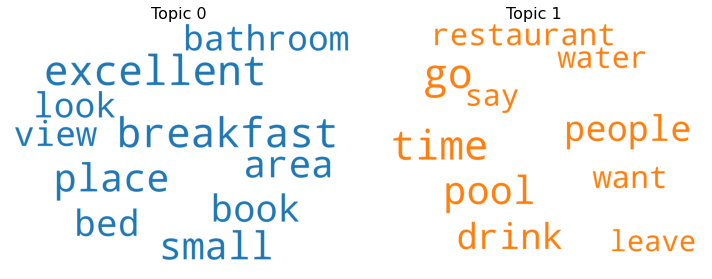

In [41]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()